In [43]:
import numpy as np
import pandas as pd
import librosa
import os
import glob
import re
import seaborn as sn
import matplotlib.pyplot as plt
import scipy
import time
import collections
import keras
import random
from keras.utils import np_utils
from keras.layers import MaxPooling1D, Conv1D, Conv2D, MaxPooling2D, GlobalAveragePooling2D, LSTM, ELU, Bidirectional, Attention
from keras.layers import Dense, Dropout, Activation, Flatten, CuDNNLSTM
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import tensorflow as tf
import pickle
from keras.utils.vis_utils import plot_model
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import keras_tuner
from keras import backend as K
import shutil
import os
import tensorflow_addons as tfa
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from operator import add
import statistics
from scipy.stats import wilcoxon


In [44]:
figure_model_name = 'lstm_base_model'
base_path = '/home/stenmarken/Plugg/kex/riktiga-kex/kex/results/lstm_results/lstm_base_model/'

new_X_test = [] # x-värden från alla folds (20496,)
new_y_test = [] # Sanna y-värden från alla folds (20496,)
new_y_pred = [] # Förutspådda y-värden från alla folds (20496,)

mini_old_X_test = [] # x-värden från gamla testerna * 1 (4096,)
mini_old_y_test = [] # Sanna y-värden från gamla testerna * 1 (4096,)
mini_old_y_pred = [] # Förutspådda y-värden från gamla testerna * 1 (4096,)

old_X_test = [] # x-värden från gamla testerna * 5 (20496,)
old_y_test = [] # Sanna y-värden från gamla testerna * 5 (20496,)
old_y_pred = [] # Förutspådda y-värden från gamla testerna * 5 (20496,)

loss = [0.0]*50 # (50,) ackumulerade loss för varje epoch
acc = [0.0]*50 # (50,) ackumulerade acc för varje epoch
val_loss = [0.0]*50 # (50,) ackumulerade val_loss för varje epoch
val_acc = [0.0]*50 # (50,) ackumulerade val_acc för varje epoch
old_sum_scores = [0.0, 0.0] # (2,) ackumulerade scores för gamla testerna
new_sum_scores = [0.0, 0.0] # (2,) ackumulerade scores för nya testerna

new_5_fold_scores = [] # (5,) scores för varje fold
old_5_fold_scores = [] # (5,) scores för varje fold

## Get old test data

In [45]:
def instrument_code(filename):
    """
    Function that takes in a filename and returns instrument based on naming convention
    """
    # Synth lead borttagen. id = 9
    class_names=['bass', 'brass', 'flute', 'guitar', 
             'keyboard', 'mallet', 'organ', 'reed', 
             'string', 'vocal']
    
    for name in class_names:
        if name in filename:
            return class_names.index(name)
    else:
        return None

In [46]:
def get_data_from_file(file):
    with open(file, "rb") as f:
        X_train_full  = pickle.load(f)

    X_train = []
    y_train = []

    for (key, value) in X_train_full:
        X_train.append(value)
        y_train.append(instrument_code(key))

    X_train_numpy = np.array(X_train)
    y_train_numpy = np.array(y_train)
    return (X_train_numpy, y_train_numpy)

In [47]:
def get_old_test_data():
    with open("CustomDataFull/testdata2000.pkl", 'rb') as f:
        X_test_full = pickle.load(f)

    X_test = []
    y_test = []

    for(key, value) in X_test_full.items():
        #temporal_value = np.mean(value, axis = 1)
        X_test.append(value)
        y_test.append(instrument_code(key))
    y_test_numpy = np.asarray(y_test)
    X_test_numpy = np.asarray(X_test)
    print(X_test_numpy.shape)
    return X_test_numpy, y_test_numpy

In [48]:
mini_old_X_test, old_y_test = get_old_test_data()
mini_old_y_test = old_y_test

num_folds = 5
for i in range(num_folds - 1):
    old_y_test = np.concatenate((old_y_test, mini_old_y_test))

(4096, 126, 13)


In [49]:
def concatenate_one_fold(model_path, history_path, new_X_test_data, new_y_test_data):
    global loss 
    global acc
    global val_loss
    global val_acc
    global new_y_pred
    global new_X_test
    global new_y_test
    global old_y_pred
    global old_y_test
    global old_X_test
    global old_sum_scores
    global new_sum_scores
    global mini_old_X_test
    global mini_old_y_test
    global mini_old_y_pred
    global new_5_fold_scores
    global old_5_fold_scores


    model = tf.keras.models.load_model(model_path)

    with open(history_path, 'rb') as f:
        history = pickle.load(f)

    fold_loss = history['loss']
    fold_acc = history['accuracy']
    fold_val_loss = history['val_loss']
    fold_val_acc = history['val_accuracy']
    
    loss = list(map(add, loss, fold_loss))
    acc = list(map(add, acc, fold_acc))
    val_loss = list(map(add, val_loss, fold_val_loss))
    val_acc = list(map(add, val_acc, fold_val_acc))
        
    new_fold_scores = model.evaluate(new_X_test_data, new_y_test_data, verbose=1)
    
    # new_fold_scores[1] är endast accuracy
    new_5_fold_scores.append(new_fold_scores[1])
    new_sum_scores = list(map(add, new_sum_scores, new_fold_scores))

    new_fold_prediction = model.predict(new_X_test_data)
    new_fold_prediction = np.argmax(new_fold_prediction, axis = 1)

    # new_y_pred och new_y_test är listor. Därför fungerar += som förväntat
    new_y_pred += new_fold_prediction.tolist()
    new_y_test += new_y_test_data.tolist()


    old_fold_scores = model.evaluate(mini_old_X_test, mini_old_y_test, verbose=1)
    
    # old_fold_scores[1] är endast accuracy
    old_5_fold_scores.append(old_fold_scores[1])
    old_sum_scores = list(map(add, old_sum_scores, old_fold_scores))

    old_fold_prediction = model.predict(mini_old_X_test)
    old_fold_prediction = np.argmax(old_fold_prediction, axis = 1)

    # old_y_pred och old_fold_prediction är listor. Därför fungerar += som förväntat
    old_y_pred += old_fold_prediction.tolist()




In [50]:
def iterate_folds(base_folder_path):
    folds_path = ['/0weyo1/', '/1weyo1/', '/2weyo1/', '/3weyo1/', '/4weyo1/']
    model_names = ['0model_weyo1.h5', '1model_weyo1.h5', '2model_weyo1.h5', '3model_weyo1.h5', '4model_weyo1.h5']
    history_names = ['0history_weyo1.history', '1history_weyo1.history', '2history_weyo1.history', '3history_weyo1.history', '4history_weyo1.history']

    file_suffix = 'weyo1'

    for(i, fold) in enumerate(folds_path):
        test_file = 'folds/' + str(i) + 'test_' + file_suffix
        fold_x_test, fold_y_test = get_data_from_file(test_file)
        model_path = base_folder_path + fold + model_names[i]
        print(model_path)
        history_path = base_folder_path + fold + history_names[i]
        concatenate_one_fold(model_path, history_path, fold_x_test, fold_y_test)
        print("En fold klar")


In [51]:
def plot_acc_loss(avg_loss, avg_acc, avg_val_loss, avg_val_acc, acc_file_path, loss_file_path):
    # Taget från https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
    # summarize history for accuracy
    global figure_model_name

    plt.plot(avg_acc)
    plt.plot(avg_val_acc)
    plt.title('Average ' + figure_model_name + ' accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig(acc_file_path)
    plt.show()

    # summarize history for loss
    plt.plot(avg_loss)
    plt.plot(avg_val_loss)
    plt.title('Average ' + figure_model_name +  ' loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig(loss_file_path)
    plt.show()

In [52]:
def plt_confusion_matrix(y_pred_par, y_test_par, confusion_matrix_file_path, figure_old_or_new_data):    
    #y_prediction = model.predict(X_test)
    #y_prediction = np.argmax(y_prediction, axis = 1)
    result = confusion_matrix(y_test_par, y_pred_par)

    df_cm = pd.DataFrame(result, index = [i for i in ["bass", "brass", "flute", "guitar", "keyboard", "mallet", "organ", "reed", "string", "vocal"]],
                    columns = [i for i in ["bass", "brass", "flute", "guitar", "keyboard", "mallet", "organ", "reed", "string", "vocal"]])

    plt.figure(figsize = (9,7))
    sn.heatmap(df_cm, annot=True, fmt='.0f')
    plt.title("Average " + figure_model_name + " " + figure_old_or_new_data + " confusion matrix")
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.savefig(confusion_matrix_file_path)
    plt.show()

In [53]:
def calc_average_fold(results_path):
    global loss 
    global acc
    global val_loss
    global val_acc
    global new_y_pred
    global new_y_test
    global old_y_pred
    global old_y_test

    avg_loss = [x / 5 for x in loss]
    avg_acc = [x / 5 for x in acc]
    avg_val_loss = [x / 5 for x in val_loss]
    avg_val_acc = [x / 5 for x in val_acc]

    plot_acc_loss(avg_loss, avg_acc, avg_val_loss, avg_val_acc, results_path + 'avg_acc.png', results_path + 'avg_loss.png')
    plt_confusion_matrix(new_y_pred, new_y_test, results_path + 'new_confusion_matrix.png', "on 5-fold test dataset")
    plt_confusion_matrix(old_y_pred, old_y_test, results_path + 'old_confusion_matrix.png', "on NSynth test dataset")
    
    statistics.stdev(new_sum_scores)
    statistics.stdev(old_sum_scores)

    avg_new_sum_scores = [x / 5 for x in new_sum_scores]
    avg_old_sum_scores = [x / 5 for x in old_sum_scores]

    f1_scores = metrics.classification_report(new_y_test, new_y_pred, digits=3)
    original_f1_scores = metrics.classification_report(old_y_test, old_y_pred, digits=3)

    score_file = results_path + 'scores.txt'
    with open(score_file, 'w') as f:
        f.write('new scores: ' +  str(avg_new_sum_scores) + '\n')
        f.write('old scores: '+ str(avg_old_sum_scores) + '\n')
        f.write('new f1 scores:\n' + str(f1_scores) + '\n')
        f.write('old f1 scores:\n' + str(original_f1_scores) + '\n')
        f.write('new_5_fold_accuracies: ' + str(new_5_fold_scores) + '\n')
        f.write('old_5_fold_accuracies: ' + str(old_5_fold_scores) + '\n')
        

In [54]:
iterate_folds(base_path)

/home/stenmarken/Plugg/kex/riktiga-kex/kex/results/lstm_results/lstm_base_model//0weyo1/0model_weyo1.h5
128/128 [==============================] - 1s 8ms/step
En fold klar
/home/stenmarken/Plugg/kex/riktiga-kex/kex/results/lstm_results/lstm_base_model//1weyo1/1model_weyo1.h5
128/128 [==============================] - 1s 7ms/step
En fold klar
/home/stenmarken/Plugg/kex/riktiga-kex/kex/results/lstm_results/lstm_base_model//2weyo1/2model_weyo1.h5
128/128 [==============================] - 1s 6ms/step
En fold klar
/home/stenmarken/Plugg/kex/riktiga-kex/kex/results/lstm_results/lstm_base_model//3weyo1/3model_weyo1.h5
128/128 [==============================] - 1s 8ms/step
En fold klar
/home/stenmarken/Plugg/kex/riktiga-kex/kex/results/lstm_results/lstm_base_model//4weyo1/4model_weyo1.h5
128/128 [==============================] - 1s 8ms/step
En fold klar


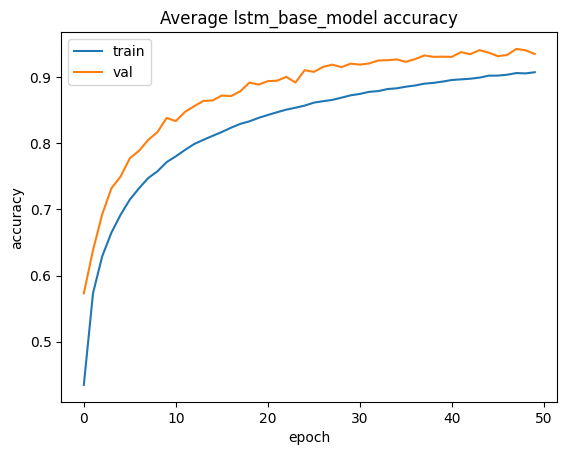

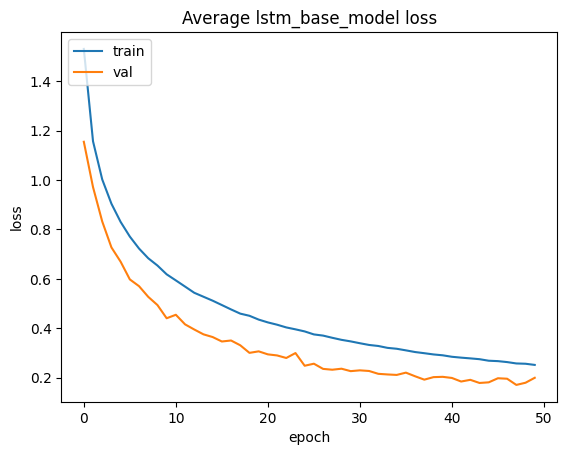

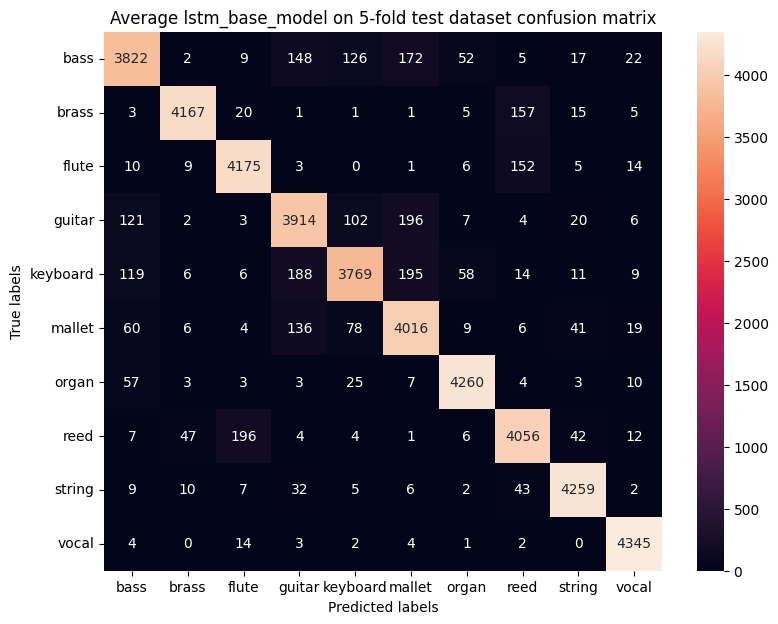

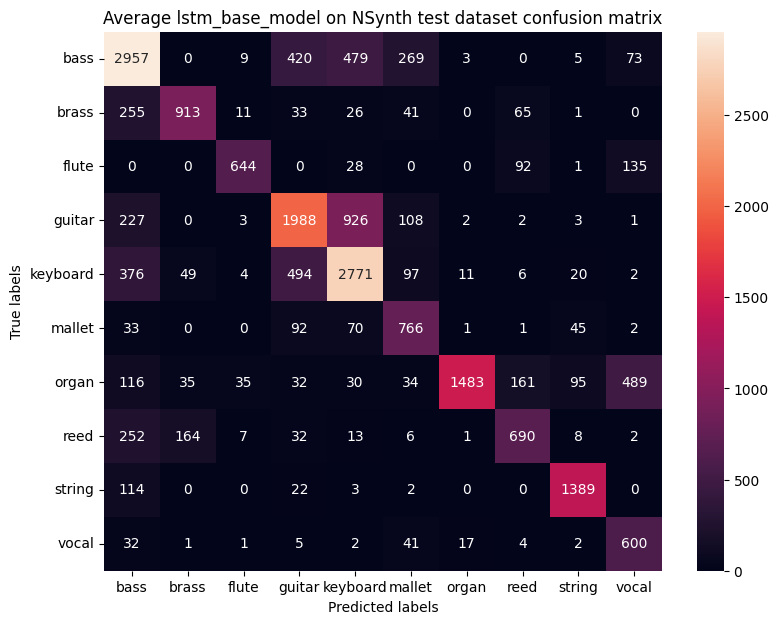

In [55]:
results_path = base_path + '/combined_results_wilcoxon/'
if not os.path.exists(results_path):
    os.makedirs(results_path)

calc_average_fold(results_path)

### Calculate Wilcoxon test 

In [59]:
cnn_optimized_accs = [0.972000002861023, 0.9679999947547913, 0.9724571704864502, 0.9718857407569885, 0.9721142649650574]
lstm_optimized_accs = [0.9628571271896362, 0.9587428569793701, 0.9628571271896362, 0.9574857354164124, 0.9593142867088318]

cnn_base_accs = [0.9631999731063843, 0.9596571326255798, 0.9619428515434265, 0.9630857110023499, 0.9673143029212952]
lstm_base_accs = [0.9297142624855042, 0.9350857138633728, 0.9265142679214478, 0.9364571571350098, 0.9331428408622742] 

stat_cnn_lstm, p_cnn_lstm = wilcoxon(lstm_optimized_accs, cnn_optimized_accs) ; print("p_cnn_lstm: " + str(p_cnn_lstm))
stat_cnn_cnn, p_cnn_cnn = wilcoxon(cnn_base_accs, cnn_optimized_accs); print("p_cnn_cnn: " + str(p_cnn_cnn))
stat_lstm_lstm, p_lstm_lstm = wilcoxon(lstm_base_accs, lstm_optimized_accs); print("p_lstm_lstm: " + str(p_lstm_lstm))


p_cnn_lstm: 5.960464477539063e-08
p_cnn_cnn: 5.960464477539063e-08
p_lstm_lstm: 5.960464477539063e-08
